### Assignment : Week 3
## Efficiently finding optimal policies in MABs

In this assignment, we will work with Multi Armed Bandit environments, and try to find the best policies using different strategies to minimize the total regret.

The aim of this exercise is to code agents capable of understanding the underlying probability distributions of the environment and finding the most optimal actions as early as possible.

You can start this assignment during/after reading Grokking Ch-4.

Let's get started!

In [6]:
# importing necessary stuff
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

# if you want to use envs from Gym, import it
# import gym, gym_bandits

Let's make a simple **2-armed Bernoulli** bandit.

If you want a cleaner code, you can implement Bandits using `class` in Python.

We have included sample code for this in `bandits.py` which you can take/import.

In [27]:
class Bernoulli_bandit():
    def __init__(self, n):
        self.N = n
        self.mean = np.random.random()
        self.probs = np.random.normal(self.mean, 1, (n,))
        self.probs = np.random.rand(n)
        self.optimal = np.max(self.probs)
        self.regret = 0.0
        
    def evaluate_choice(self, k):
        assert 1 <= k <= self.N
        reward = np.random.binomial(1, self.probs[k-1])
        self.regret += self.optimal - reward
        return reward

In [247]:
class Gaussian_bandit():
    def __init__(self, n):
        self.N = n
        self.means = np.random.rand(n)
        self.variances = np.sqrt(means)*(np.random.rand(n)/2 + 0.5)
        self.optimal = np.max(self.means)
        self.regret = 0.0

    def evaluate_choice(self, k):
        assert 1 <= k <= self.N
        reward = np.random.uniform(self.means[k-1], self.variances[k-1]) 
        self.regret += np.random.uniform(self.optimal, self.variances[k-1]) - reward
        return reward

In [42]:
# strategy function takes in the environment function, number of actions, and a selector function
# it also takes in the number of episodes to run the strategy for (higher episodes = more accurate Q values)

def test_strategy(env, n_actions, selector, n_episodes = 1000):
    
    # initialize Q and N to 0s
    Q = np.zeros(n_actions)
    N = np.zeros(n_actions)

    # loop for n_episodes
    for e in tqdm(range(n_episodes)):
        
        # selector function takes in current Q and returns an action
        # modify the selector function according to the strategy
        action = selector(Q)

        # get the reward from the environment
        reward = env(action)

        # update N and Q
        N[action] += 1
        Q[action] += (reward - Q[action])/N[action]

    # return the best action
    return np.argmax(Q)

Implementing the simplest selector using pure-exploration strategy.

As you can see, it returns the optimal action. Let's check if that's indeed true.

We can do that by revealing the actual `probs` distribution.

In [45]:
probs

array([0.80499935, 0.65065254])

As expected, our pure exploration strategy does indeed return the optimal action for this Bernoulli bandit. 

You can try generating new bandits with different `probs` and try out the same.

With all this in place, here's what you have to do -

Recall that, the regret $\mathcal{T}$ is given by,

$$\mathcal{T}=\sum  _{e=1} ^{E} \mathbb{E} \left[ v_* - q_* \left( A_e \right) \right]$$

We can only calculate it when we have the $v_*$ and $q_*$ functions known beforehand. Since we are making the MDPs from scratch, that's not an issue for us right now.

But remember, in real-life problems, these functions are not known. Hence we must be aware of multiple policy finding strategies and try the one which gives best results fastest.

### Todo 0

Implement the calculation of the total regret $\mathcal{T}$ for your strategy.

To do this, you will need to store the rewards obtained each episode. Modify the `strategy` function accordingly.

In [10]:
# function to calculate total regret

def regret(rewards, probs):
    
    return len(rewards)*np.max(probs) - sum(rewards)


### Todo 1

Now, let's implement some other selection strategies and compare their regret with the simple exploration strategy.

Note that some of these strategies involve hyperparameter(s) which need to be manually adjusted. You have to play around with the values and see which one gives you best results.

This is known as "hyperparameter tuning" and is quite commonly done while working with complex models (including neural networks). Personally, you should try out some natural values (including the ones given in the book) along with some extreme values where it is easy to manually verify the correctness of your strategy.

In [16]:
# epsilon-greedy strategy
# Already implemented for you coz I am nice

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(1, len(Q) + 1)
    else:
        return np.argmax(Q) + 1

In [163]:
# exponentially decaying epsilon greedy strategy

def exponentially_decaying_epsilon_greedy(Q, epsilon, gamma):
    
    epsilon *= gamma
    if np.random.random() < epsilon:
        return np.random.randint(1, len(Q) + 1), epsilon
    return np.argmax(Q) + 1, epsilon


In [219]:
# softmax action selection strategy

def softmax_strategy(Q, temperature):
    
    choice_probabilities = [np.exp(val/temperature) for val in Q]
    choice_probabilities = choice_probabilities/sum(choice_probabilities)

    return np.random.choice(range(1, len(Q)+1), p=choice_probabilities)


In [192]:
from math import log, log10

In [266]:
# upper confidence bound strategy

def ucb(Q, N, c):
    s = sum(N)
    choice = np.argmax([Q[i] + np.sqrt(log(s)/N[i]) if N[i] >= 1 else Q[i] for i in range(len(Q))]) + 1
    return choice


In [267]:
# thompson sampling strategy

def thompson_sampling(Q, N, alpha, beta):
    samples = np.random.normal(loc=Q, scale = alpha/(np.sqrt(N) + beta))
    choice = np.argmax(samples) + 1
    return choice


### Todo 2

Run each strategy for 2-armed bandit environment and compare the total regrets.

You can also try plotting the regret vs episode graph and check if it matches the expected result from Grokking

In [17]:
# import plotting libraries

import matplotlib.pyplot as plt

In [212]:
bandit = Bernoulli_bandit(10)

In [213]:
bandit.probs

array([0.31445313, 0.84147618, 0.61832652, 0.83918859, 0.99346809,
       0.50397116, 0.81957353, 0.51309866, 0.05625363, 0.95866894])

In [161]:
def implement_epsilon_greedy(epsilon=0.1, gamma=0.9, num_episodes = 10000):
    global bandit
    bandit.regret = 0
    gamma_power = gamma
    Q = np.zeros(bandit.N)
    N = np.zeros(bandit.N)
    for episode in range(num_episodes):
        choice = epsilon_greedy(Q, epsilon)
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
    return np.argmax(Q) + 1

In [197]:
def implement_decaying_epsilon_greedy(epsilon, gamma=0.9, num_episodes = 10000):
    global bandit
    min_to_max_ratio = 0.01
    max_epsilon = epsilon
    min_epsilon = min_to_max_ratio*epsilon
    decay_rate = 0.05
    decay_episodes = int(num_episodes*decay_rate)
    remaining_episodes = num_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(log10(min_to_max_ratio), 0, decay_episodes)
    epsilons *= max_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, remaining_episodes), mode='constant', constant_values=min_epsilon)
    bandit.regret = 0
    gamma_power = gamma
    Q = np.zeros(bandit.N)
    N = np.zeros(bandit.N)
    for episode in range(num_episodes):
        choice = epsilon_greedy(Q, epsilons[episode])
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
        
    return np.argmax(Q) + 1

In [136]:
def implement_softmax(temperature, gamma=0.9, num_episodes = 10000):
    global bandit
    bandit.regret = 0
    gamma_power = gamma
    Q = np.zeros(bandit.N)
    N = np.zeros(bandit.N)
    for episode in range(num_episodes):
        choice = softmax_strategy(Q, temperature)
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
    return np.argmax(Q) + 1

In [231]:
def implement_ucb(c, gamma=0.9, num_episodes = 10000):
    global bandit
    bandit.regret = 0
    gamma_power = gamma
    Q = np.zeros(bandit.N)
    N = np.ones(bandit.N)
    for episode in range(num_episodes):
        choice = ucb(Q, N, c)
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
    return np.argmax(Q) + 1

In [155]:
def implement_thompson_sampling(alpha=1, beta=0, gamma = 0.9, num_episodes = 10000):
    global bandit
    bandit.regret = 0
    gamma_power = gamma
    Q = np.zeros(bandit.N)
    N = np.zeros(bandit.N)
    for episode in range(num_episodes):
        choice = thompson_sampling(Q, N, alpha, beta)
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
    return np.argmax(Q) + 1

In [216]:
epsilon_values = np.linspace(0, 1, 101)
regrets = []
choices = []
for epsilon in epsilon_values:
    optimal_choice = implement_decaying_epsilon_greedy(epsilon)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

1
5
7
5
10
5
5
5
5
10
10
5
5
5
4
5
5
5
5
5
5
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
5
5
5
5
5
5
5
5
5
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


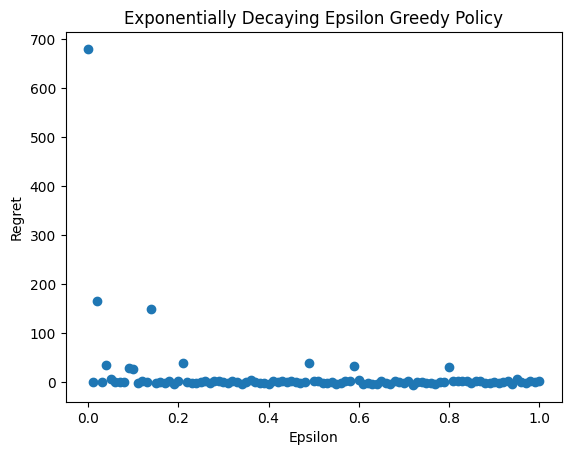

In [217]:
plt.ylabel('Regret')
plt.xlabel('Epsilon')
plt.title('Exponentially Decaying Epsilon Greedy Policy')
plt.scatter(epsilons, regrets)

In [93]:
# epsilons = np.linspace(0, 1, 101)
epsilon_values = [0.1]
values = []
rewards = []
results = []
for i in range(50):
    band = Bernoulli_bandit(n)
    epsilon = epsilon_values[0]
    n = 2
    band.regret = 0
    gamma = 0.9
    gamma_power = 0.9
    Q = np.zeros(n)
    for episode in range(10000):
        choice = epsilon_greedy(Q, epsilon)
        Q[choice-1] += gamma_power*band.evaluate_choice(choice)
        gamma_power *= gamma
    rewards.append(band.regret)
    results.append(abs(band.probs[0] - band.probs[1])/band.regret)

In [214]:
epsilons = np.linspace(0, 1, 101)
regrets = []
for epsilon in epsilons:
    bandit.regret = 0
    gamma = 0.9
    gamma_power = 0.9
    Q = np.zeros(n)
    N  = np.zeros(n)
    for episode in range(10000):
        choice = epsilon_greedy(Q, epsilon)
        Q[choice-1] = (Q[choice-1]*N[choice-1] + gamma*bandit.evaluate_choice(choice))/(N[choice-1] + 1)
        N[choice-1] += 1
        gamma_power *= gamma
    bandit.regret = 0
    choice = np.argmax(Q) + 1
    for episode in range(10000):
        bandit.evaluate_choice(choice)
    regrets.append(bandit.regret)

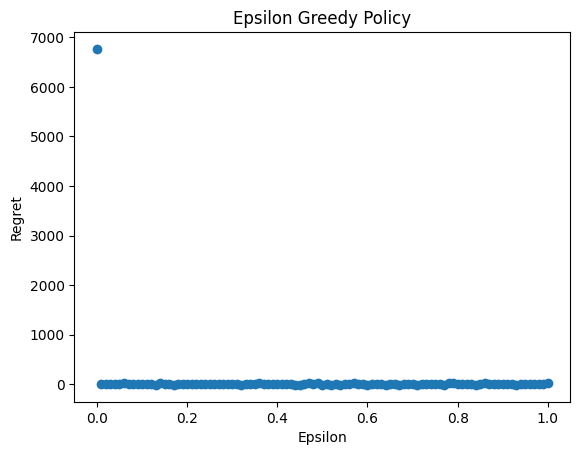

In [215]:
plt.ylabel('Regret')
plt.title('Epsilon Greedy Policy')
plt.xlabel('Epsilon')
plt.scatter(epsilons, regrets)

In [221]:
temperature_values = np.linspace(0, 1, 101)[1:]
regrets = []
choices = []
for temp in temperature_values:
    optimal_choice = implement_softmax(temp)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

5
7
10
10
5
5
2
5
10
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


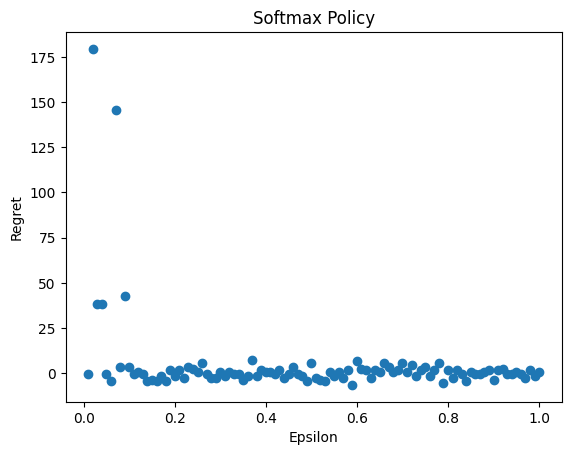

In [223]:
plt.ylabel('Regret')
plt.title('Softmax Policy')
plt.xlabel('Epsilon')
plt.scatter(temperature_values, regrets)

In [235]:
c_values = np.linspace(0, 1, 101)
regrets = []
choices = []
for c in c_values:
    optimal_choice = implement_ucb(c)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


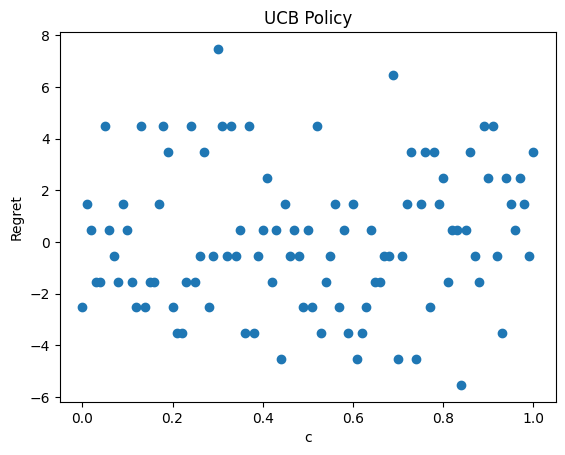

In [237]:
plt.ylabel('Regret')
plt.title('UCB Policy')
plt.xlabel('c')
plt.scatter(c_values, regrets)

### Todo 3

The 2-armed bandits might be too simple for us to actually see substantial difference in the regret of these strategies. 

Let's now create a more complicated bandit environment and replicate our results on it.

We will now implement a 10-armed Gaussian bandit. 

As required, it will have possible actions and each action will generate a reward sampled from a Gaussian distribution.

Hence, each "arm" will have a randomly generated $\mu$ and $\sigma$, and the rewards will be generated with probabilities following the $\mathcal{N}(\mu, \sigma^2)$ distribution. 

In [245]:
# 10 arm gaussian bandit
n = 10
means = 10*np.random.rand(n)

variances = np.sqrt(means)*np.random.rand(n)


array([0.09211315, 2.75110717, 1.92806572, 0.58882617, 1.8422045 ,
       0.37262226, 0.9470867 , 0.36131188, 2.00999456, 0.58976011])

In [254]:
bandit = Gaussian_bandit(n)

In [255]:
bandit.means

array([0.26309991, 0.9499895 , 0.88206459, 0.77885896, 0.31092948,
       0.79329077, 0.25715122, 0.05922146, 0.29544353, 0.45506457])

### Todo 4

Test the different strategies on the 10-armed gaussian bandit and verify your results.

In [256]:
epsilon_values = np.linspace(0, 1, 101)
regrets = []
choices = []
for epsilon in epsilon_values:
    optimal_choice = implement_epsilon_greedy(epsilon)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


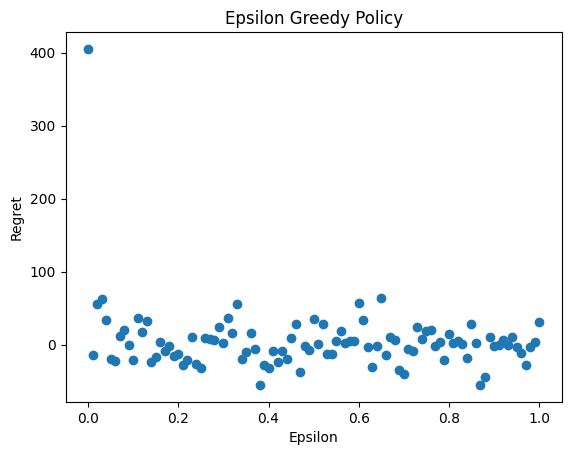

In [257]:
plt.ylabel('Regret')
plt.title('Epsilon Greedy Policy')
plt.xlabel('Epsilon')
plt.scatter(epsilons, regrets)

In [258]:
epsilon_values = np.linspace(0, 1, 101)
regrets = []
choices = []
for epsilon in epsilon_values:
    optimal_choice = implement_decaying_epsilon_greedy(epsilon)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

1
1
2
2
2
1
1
2
2
3
2
3
3
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


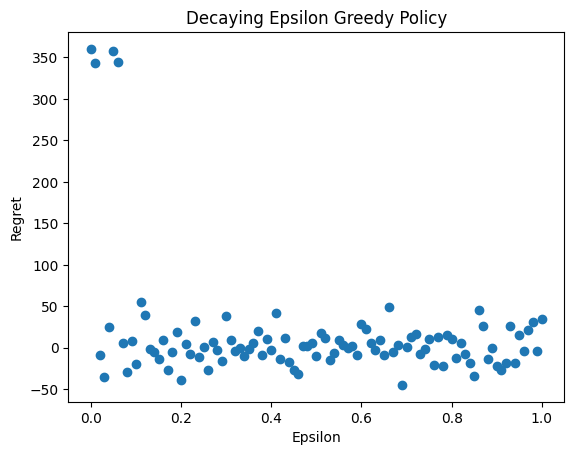

In [260]:
plt.ylabel('Regret')
plt.title('Decaying Epsilon Greedy Policy')
plt.xlabel('Epsilon')
plt.scatter(epsilons, regrets)

In [261]:
temperature_values = np.linspace(0, 1, 101)[1:]
regrets = []
choices = []
for temp in temperature_values:
    optimal_choice = implement_softmax(temp)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

7
3
1
5
1
1
1
9
3
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


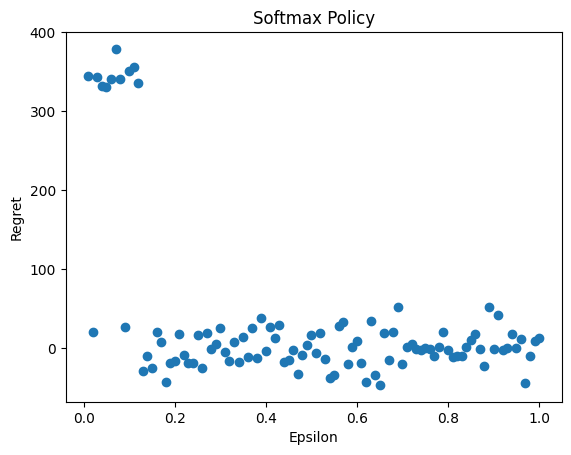

In [262]:
plt.ylabel('Regret')
plt.title('Softmax Policy')
plt.xlabel('Epsilon')
plt.scatter(temperature_values, regrets)

In [268]:
c_values = np.linspace(0, 1, 101)
regrets = []
choices = []
for c in c_values:
    optimal_choice = implement_ucb(c)
    bandit.regret = 0
    print(optimal_choice)
    for episode in range(1000):
        bandit.evaluate_choice(optimal_choice)
    regrets.append(bandit.regret)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


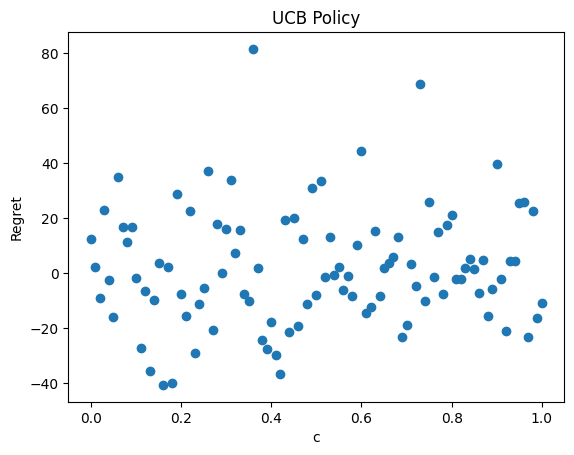

In [269]:
plt.ylabel('Regret')
plt.title('UCB Policy')
plt.xlabel('c')
plt.scatter(c_values, regrets)